[View in Colaboratory](https://colab.research.google.com/github/Naritoshi/colabo_deeplearning_practice/blob/master/cnn_kaggle_data_classifier.ipynb)

#kaggleからデータ取得し、画像分類する（未完成）

##Kaggleからデータを取得する

###KaggleAPIのインストール

In [11]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d6/3c/92/375decc0cf0a65b281db3cca9b8e21dc27b8ebc4d1ce29afca
Successfully built kaggle


###kaggle の認証設定

認証の取得は、 [ここ](https://qiita.com/h_kobayashi1125/items/749f63577a7353771969)を参考にしました。

「kaggle.json」を ```「https://www.kaggle.com/アカウント名/account」```より取得します。

取得したファイルをGoogleDriveにアップロードすます。

取得したファイルを「~/.kaggle/kaggle.json」に配置します。

In [12]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


アップロードされた確認します。

In [16]:
import os
os.listdir('/content/.kaggle/')

['kaggle.json']

### DataSetのダウンロード

KaggelAPIを使って、ファイルをダウンロードする

In [17]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Downloaded 198MB of 198MB to /content/.kaggle/datasets/moltean/fruits


ダウンロードできたか確認します。

In [18]:
os.listdir('/content/.kaggle/datasets/moltean/fruits')

['fruits.zip', 'fruits-360_dataset_2018_06_03.zip']

ダウンロードしたファイルを解凍します。

In [19]:
%%bash
unzip /content/.kaggle/datasets/moltean/fruits/fruits-360_dataset_2018_06_03.zip

Archive:  /content/.kaggle/datasets/moltean/fruits/fruits-360_dataset_2018_06_03.zip
   creating: fruits-360/
  inflating: fruits-360/LICENSE      
   creating: fruits-360/papers/
  inflating: fruits-360/papers/fruit-recognition-images.pdf  
  inflating: fruits-360/readme.md    
   creating: fruits-360/test-multiple_fruits/
  inflating: fruits-360/test-multiple_fruits/apple_apricot_nectarine_peach_peach(flat)_pomegranate_pear_plum.jpg  
  inflating: fruits-360/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum.jpg  
  inflating: fruits-360/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum_2.jpg  
  inflating: fruits-360/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum_3.jpg  
   creating: fruits-360/Training/
   creating: fruits-360/Training/Apple Braeburn/
  inflating: fruits-360/Training/Apple Braeburn/0_100.jpg  
  inflating: fruits-360/Training/Apple Braeburn/100_100.jpg  
  inflating: fruits-360/Training/Ap

解凍できたか確認します。
フォルダ名「fruits-360」が出来ているはずです。

In [20]:
os.listdir()

['datalab',
 '.ipython',
 '.forever',
 '.rnd',
 '.local',
 '.kaggle',
 '.cache',
 'fruits-360',
 '.config']

###データの確認

画像を1つ表示する

(100, 100)


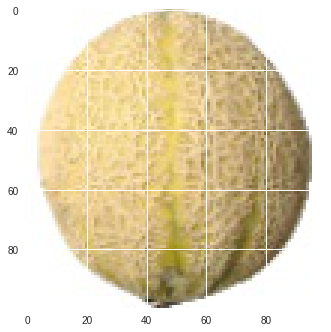

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('fruits-360/Training/Cantaloupe 2/257_100.jpg')

#サイズは、100x100のようです
print(img.size)
plt.imshow(img)
plt.show()

複数の画像を表示する

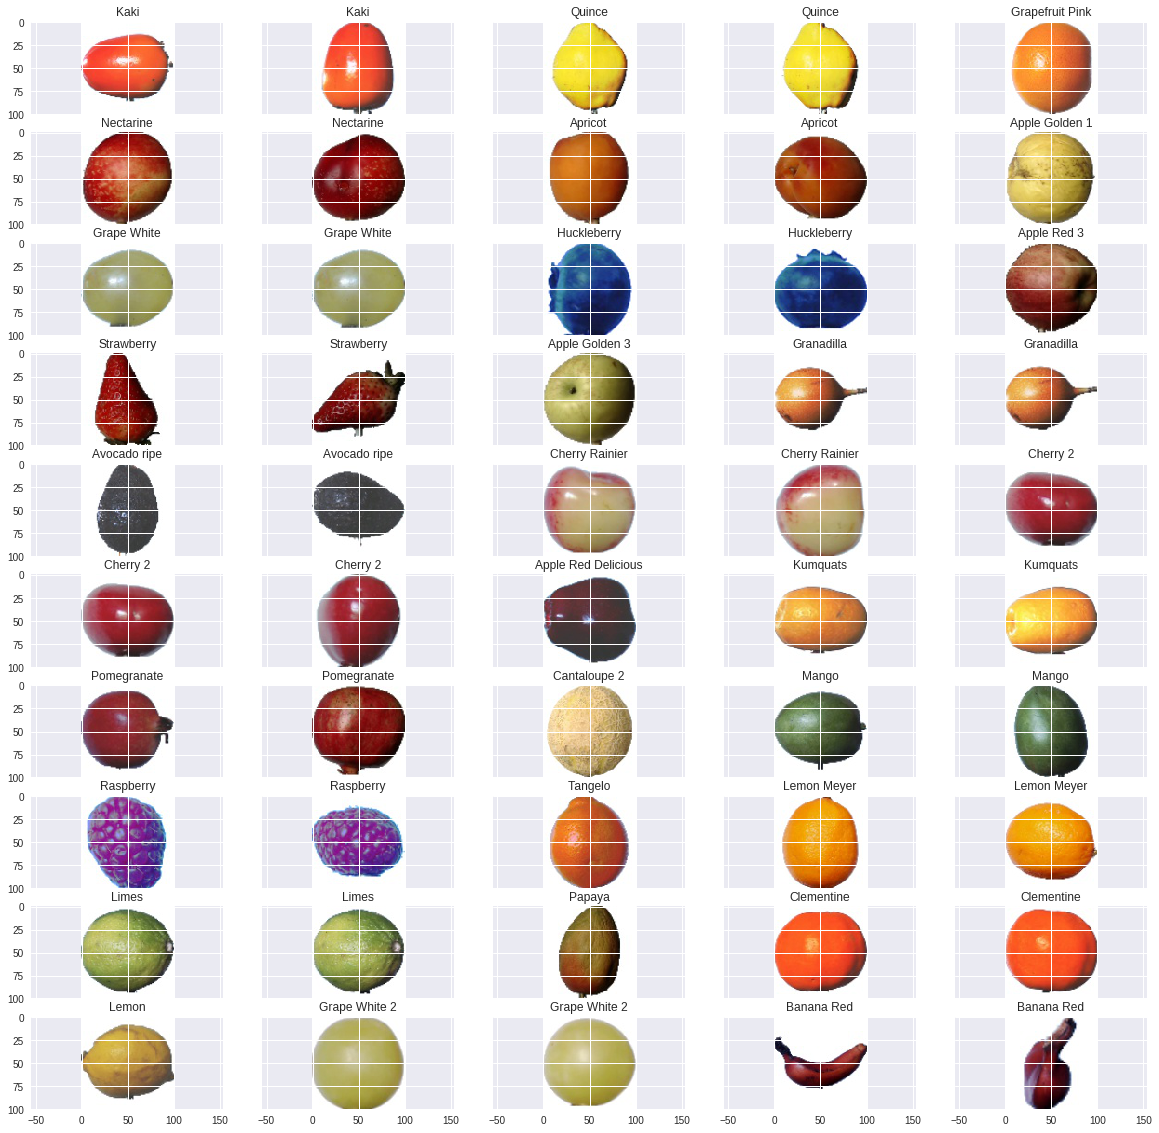

In [23]:
import glob

#画像のパスを取得する
path_list = glob.glob('fruits-360/*/*/*.jpg')

#figsizeで大きさを指定できます
fig,ax = plt.subplots(nrows=10,ncols=5, sharex=True, sharey=True,figsize=(20, 20))

#一次元で扱えるようにする
ax = ax.flatten()

for i in range(50):
  #100掛けて、適当に表示
  img_path = path_list[i * 100]
  img = Image.open(img_path)
  #ファイル名を表示する
  name = img_path.split('/')[2]
  ax[i].set_title(name)
  ax[i].imshow(img)
  

##データセットを作る

[LabeledImageDataset](https://github.com/chainer/chainer/blob/v4.1.0/chainer/datasets/image_dataset.py)を利用して、データセットを作ります。

画像のパス、正解ラベル(int型)をタプルにした配列とする必要があります。

In [0]:
#LabeledImageDatasetを利用して、データセットを作ります。
#LabeledImageDatasetは、「画像のパス、正解ラベル(int型)をタプル」or「画像パス,正解ラベル」 にした、配列とする必要があります。

#画像パス,正解ラベルの配列でやってみます。
#画像のパスを取得する
IMG_LABLEL_PATH = ('fruits-360/*/*/')
path_list = glob.glob('fruits-360/*/*/*.jpg')
for path in path_list:
  

In [29]:
#これで重複なく、ラベルとなるフォルダが取れます。
IMG_LABLEL_PATH = ('fruits-360/*/*/')
label_path_list = glob.glob(IMG_LABLEL_PATH)
#5件だけ表示
print(label_path_list[:5])

#ラベルにインデックスを付ける

['fruits-360/Validation/Kaki/', 'fruits-360/Validation/Quince/', 'fruits-360/Validation/Grapefruit Pink/', 'fruits-360/Validation/Nectarine/', 'fruits-360/Validation/Apricot/']
